## Import library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [21]:
def get_available_gpus():
    """
    code from http://stackoverflow.com/questions/38559755/how-to-get-current-available-gpus-in-tensorflow
    """
    from tensorflow.python.client import device_lib as _device_lib
    local_device_protos = _device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' or x.device_type == 'CPU']

In [22]:
get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

## Define path

In [11]:
path = "../img/detection"
path_dog = os.path.join(path, 'dog')
path_nodog = os.path.join(path, 'no_dog')

path_dog_corgi = os.path.join(path_dog, 'corgi')
path_dog_shiba = os.path.join(path_dog, 'shiba')
path_dog_gr = os.path.join(path_dog, 'gr')

path_nodog_parrot = os.path.join(path_nodog, 'parrot')
path_nodog_tiger = os.path.join(path_nodog, 'tiger')
path_nodog_rabbit = os.path.join(path_nodog, 'rabbit')
class_names = ['dog', 'no_dog']

In [12]:
# clear error image
from PIL import Image
path_list = [path_dog_corgi, path_dog_shiba, path_dog_gr, path_nodog_parrot,
            path_nodog_tiger, path_nodog_rabbit]

for p in path_list:
    file_list = os.listdir(p)
    for n in file_list:
        file_path = os.path.join(p, n)
        try:
            img = Image.open(file_path)
        except:
            os.remove(file_path)

## EDA

In [13]:
split = 0.2

In [14]:
num_corgi = len(os.listdir(path_dog_corgi))
num_shiba = len(os.listdir(path_dog_shiba))
num_gr = len(os.listdir(path_dog_gr))
num_dogs = num_gr + num_shiba + num_corgi

num_parrot = len(os.listdir(path_nodog_parrot))
num_tiger = len(os.listdir(path_nodog_tiger))
num_rabbit = len(os.listdir(path_nodog_rabbit))
num_nodogs = num_parrot + num_tiger + num_rabbit

total_img_num = num_dogs + num_nodogs

total_val = total_img_num * split
total_train = total_img_num - total_val

print('total dog images:', num_dogs)
print('total no_dog images:', num_nodogs)
print('total images:', total_img_num)
print('number of training data:', total_train)
print('number of validation:', total_val)

total dog images: 3321
total no_dog images: 3199
total images: 6520
number of training data: 5216.0
number of validation: 1304.0


## Train test split

In [15]:
epochs = 20 #10
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 128

In [16]:
# Generator
data_generator = ImageDataGenerator(rescale=1./255, validation_split=split)

In [17]:
# Load images from the disk, applies rescaling, and resizes the images

train_generator = data_generator.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='training') # set as training data

validation_generator = data_generator.flow_from_directory(
    directory=path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    subset='validation') # set as validation data

Found 5217 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.


## Labels

In [ ]:
import collections

def count_label(generator):
    l = len(generator)
    counter = collections.Counter()
    for i in range(l):
        _, label = generator[i]
        unique, counts = np.unique(label, return_counts=True)
        count_label = dict(zip(unique, counts))
        counter.update(count_label) 
    result = dict(counter)
    return result

In [ ]:
train_count = count_label(train_generator)
val_count = count_label(validation_generator)

print("Training labels:")
print(train_count)
print("Validation labels:")
print(val_count)

In [ ]:
def get_image_label(generator):
    l = len(generator)
    images = []
    labels = []
    for i in range(l):
        image, label = generator[i]
        images.append(image.tolist())
        labels.append(label.tolist())
    return [images, labels]

In [ ]:
val_img_lab = get_image_label(validation_generator)

## Sample visualisation

In [11]:
sample_img_train, sample_label_train = next(train_generator)

In [ ]:
def plotImg(img, label):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img[i])
        plt.xlabel(class_names[int(label[i])])
    plt.show()

In [ ]:
plotImg(sample_img_train, sample_label_train)

## Model

In [12]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
____________________________

## Train model

In [14]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = total_train // batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_val // batch_size
)

Epoch 1/20


C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 80s 2s/step - loss: 0.8352 - acc: 0.6310 - val_loss: 0.5327 - val_acc: 0.7617
Epoch 2/20
41/41 [==============================] - 68s 2s/step - loss: 0.4592 - acc: 0.7941 - val_loss: 0.4633 - val_acc: 0.7961
Epoch 3/20
41/41 [==============================] - 68s 2s/step - loss: 0.4060 - acc: 0.8245 - val_loss: 0.4767 - val_acc: 0.7789
Epoch 4/20
41/41 [==============================] - 68s 2s/step - loss: 0.3359 - acc: 0.8641 - val_loss: 0.4312 - val_acc: 0.8133
Epoch 5/20
41/41 [==============================] - 68s 2s/step - loss: 0.2730 - acc: 0.8911 - val_loss: 0.4247 - val_acc: 0.8219
Epoch 6/20
41/41 [==============================] - 68s 2s/step - loss: 0.2113 - acc: 0.9196 - val_loss: 0.4509 - val_acc: 0.8172
Epoch 7/20
41/41 [==============================] - 69s 2s/step - loss: 0.1482 - acc: 0.9458 - val_loss: 0.5191 - val_acc: 0.7992
Epoch 8/20
41/41 [==============================] - 68s 2s/step - loss: 0.1182 - acc: 0.9589 - val_lo

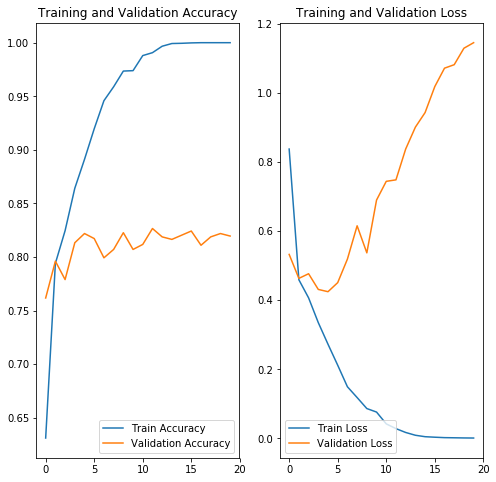

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(val_img_lab[0],  val_img_lab[1], verbose=2)

print('\nTest accuracy:', test_acc)

## Dropout

In [16]:
model_1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)       

In [17]:
history = model_1.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 3/41 [=>............................] - ETA: 1:23 - loss: 2.7887 - acc: 0.4661

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 72s 2s/step - loss: 0.8719 - acc: 0.5773 - val_loss: 0.5303 - val_acc: 0.7664
Epoch 2/20
41/41 [==============================] - 70s 2s/step - loss: 0.4813 - acc: 0.7778 - val_loss: 0.4779 - val_acc: 0.7805
Epoch 3/20
41/41 [==============================] - 70s 2s/step - loss: 0.4509 - acc: 0.7989 - val_loss: 0.4588 - val_acc: 0.8062
Epoch 4/20
41/41 [==============================] - 70s 2s/step - loss: 0.3916 - acc: 0.8377 - val_loss: 0.4124 - val_acc: 0.8164
Epoch 5/20
41/41 [==============================] - 70s 2s/step - loss: 0.3560 - acc: 0.8496 - val_loss: 0.4292 - val_acc: 0.8172
Epoch 6/20
41/41 [==============================] - 70s 2s/step - loss: 0.2962 - acc: 0.8822 - val_loss: 0.4650 - val_acc: 0.7867
Epoch 7/20
41/41 [==============================] - 70s 2s/step - loss: 0.2534 - acc: 0.8995 - val_loss: 0.4799 - val_acc: 0.8078
Epoch 8/20
41/41 [==============================] - 70s 2s/step - loss: 0.1997 - acc: 0.9191 - val_lo

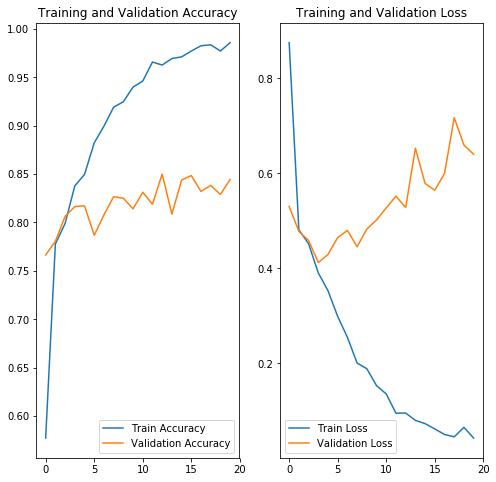

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [19]:
model_2 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)       

In [20]:
history = model_2.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
12/41 [=======>......................] - ETA: 50s - loss: 0.9884 - acc: 0.5215

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 71s 2s/step - loss: 0.7134 - acc: 0.6238 - val_loss: 0.5281 - val_acc: 0.7477
Epoch 2/20
41/41 [==============================] - 69s 2s/step - loss: 0.5160 - acc: 0.7620 - val_loss: 0.5081 - val_acc: 0.7352
Epoch 3/20
41/41 [==============================] - 69s 2s/step - loss: 0.4503 - acc: 0.8016 - val_loss: 0.4789 - val_acc: 0.7578
Epoch 4/20
41/41 [==============================] - 70s 2s/step - loss: 0.3997 - acc: 0.8329 - val_loss: 0.4043 - val_acc: 0.8281
Epoch 5/20
41/41 [==============================] - 70s 2s/step - loss: 0.3708 - acc: 0.8453 - val_loss: 0.4167 - val_acc: 0.8211
Epoch 6/20
41/41 [==============================] - 70s 2s/step - loss: 0.3291 - acc: 0.8620 - val_loss: 0.3963 - val_acc: 0.8344
Epoch 7/20
41/41 [==============================] - 80s 2s/step - loss: 0.3020 - acc: 0.8754 - val_loss: 0.4398 - val_acc: 0.8055
Epoch 8/20
41/41 [==============================] - 72s 2s/step - loss: 0.2586 - acc: 0.8991 - val_lo

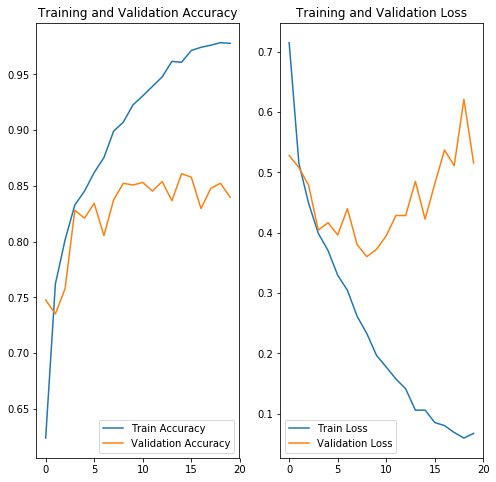

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

In [18]:
model_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(256, activation='relu'),
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)       

In [19]:
history = model_3.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 5/40 [==>...........................] - ETA: 41s - loss: 0.6368 - acc: 0.6313

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


40/40 [==============================] - 115s 3s/step - loss: 0.7632 - acc: 0.5449 - val_loss: 0.6351 - val_acc: 0.6383
Epoch 2/20
40/40 [==============================] - 102s 3s/step - loss: 0.5949 - acc: 0.7107 - val_loss: 0.4918 - val_acc: 0.7922
Epoch 3/20
40/40 [==============================] - 102s 3s/step - loss: 0.5164 - acc: 0.7671 - val_loss: 0.4714 - val_acc: 0.7797
Epoch 4/20
40/40 [==============================] - 102s 3s/step - loss: 0.4784 - acc: 0.7881 - val_loss: 0.4489 - val_acc: 0.8000
Epoch 5/20
40/40 [==============================] - 102s 3s/step - loss: 0.4552 - acc: 0.8138 - val_loss: 0.4341 - val_acc: 0.7977
Epoch 6/20
40/40 [==============================] - 104s 3s/step - loss: 0.4379 - acc: 0.8165 - val_loss: 0.4169 - val_acc: 0.8172
Epoch 7/20
40/40 [==============================] - 102s 3s/step - loss: 0.3883 - acc: 0.8336 - val_loss: 0.3989 - val_acc: 0.8250
Epoch 8/20
40/40 [==============================] - 102s 3s/step - loss: 0.3526 - acc: 0.8607 

KeyboardInterrupt: 

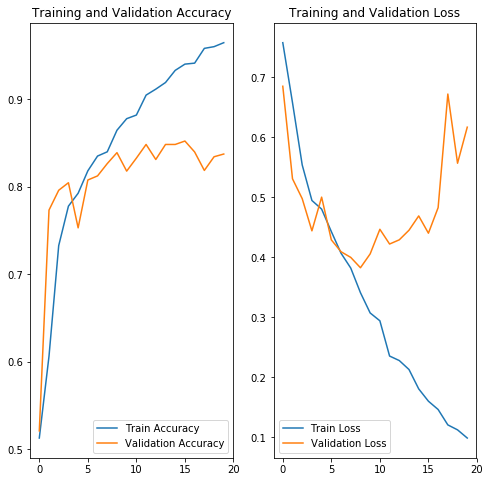

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')

plt.show()

3*Droupout(0.5, 0.7, 0.8) Epoch 12-13 Train(0.9) Val(0.84)

In [12]:
model_4 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model_4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 64)       

In [13]:
history = model_4.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 1/41 [..............................] - ETA: 4:21 - loss: 0.6927 - acc: 0.5078

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 109s 3s/step - loss: 0.7977 - acc: 0.5413 - val_loss: 0.6672 - val_acc: 0.6555
Epoch 2/20
41/41 [==============================] - 90s 2s/step - loss: 0.5782 - acc: 0.7148 - val_loss: 0.5078 - val_acc: 0.7695
Epoch 3/20
41/41 [==============================] - 85s 2s/step - loss: 0.5006 - acc: 0.7756 - val_loss: 0.4764 - val_acc: 0.7875
Epoch 4/20
41/41 [==============================] - 78s 2s/step - loss: 0.4649 - acc: 0.7932 - val_loss: 0.5432 - val_acc: 0.7305
Epoch 5/20
41/41 [==============================] - 83s 2s/step - loss: 0.4372 - acc: 0.8142 - val_loss: 0.4232 - val_acc: 0.8039
Epoch 6/20
41/41 [==============================] - 88s 2s/step - loss: 0.3846 - acc: 0.8365 - val_loss: 0.4445 - val_acc: 0.8023
Epoch 7/20
41/41 [==============================] - 83s 2s/step - loss: 0.3283 - acc: 0.8676 - val_loss: 0.4450 - val_acc: 0.8070
Epoch 8/20
41/41 [==============================] - 87s 2s/step - loss: 0.2769 - acc: 0.8882 - val_l

In [14]:
model_5 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.7),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

model_5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 64)       

In [15]:
history = model_5.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 2/41 [>.............................] - ETA: 1:47 - loss: 1.2201 - acc: 0.5078

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


41/41 [==============================] - 80s 2s/step - loss: 0.8175 - acc: 0.6244 - val_loss: 0.5579 - val_acc: 0.7250
Epoch 2/20
41/41 [==============================] - 88s 2s/step - loss: 0.5033 - acc: 0.7669 - val_loss: 0.5046 - val_acc: 0.7500
Epoch 3/20
41/41 [==============================] - 87s 2s/step - loss: 0.4707 - acc: 0.7938 - val_loss: 0.4481 - val_acc: 0.7898
Epoch 4/20
41/41 [==============================] - 81s 2s/step - loss: 0.4187 - acc: 0.8253 - val_loss: 0.4412 - val_acc: 0.8117
Epoch 5/20
41/41 [==============================] - 92s 2s/step - loss: 0.4095 - acc: 0.8268 - val_loss: 0.4061 - val_acc: 0.8242
Epoch 6/20
41/41 [==============================] - 95s 2s/step - loss: 0.3767 - acc: 0.8422 - val_loss: 0.3994 - val_acc: 0.8258
Epoch 7/20
41/41 [==============================] - 89s 2s/step - loss: 0.3371 - acc: 0.8597 - val_loss: 0.3734 - val_acc: 0.8445
Epoch 8/20
41/41 [==============================] - 83s 2s/step - loss: 0.3392 - acc: 0.8610 - val_lo

In [20]:
model_6 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.8),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.8),
    Dense(1, activation='sigmoid')
])

model_6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 64)       

In [ ]:
history = model_6.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20
 5/40 [==>...........................] - ETA: 58s - loss: 0.5131 - acc: 0.7625

C:\Users\ABC\Anaconda3\lib\site-packages\PIL\Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


40/40 [==============================] - 112s 3s/step - loss: 0.5941 - acc: 0.6785 - val_loss: 0.5050 - val_acc: 0.7625
Epoch 2/20
40/40 [==============================] - 104s 3s/step - loss: 0.4856 - acc: 0.7768 - val_loss: 0.4593 - val_acc: 0.7875
Epoch 3/20
40/40 [==============================] - 118s 3s/step - loss: 0.4497 - acc: 0.7999 - val_loss: 0.4504 - val_acc: 0.7992
Epoch 4/20
40/40 [==============================] - 149s 4s/step - loss: 0.4294 - acc: 0.8180 - val_loss: 0.4189 - val_acc: 0.8211
Epoch 5/20
40/40 [==============================] - 128s 3s/step - loss: 0.3931 - acc: 0.8324 - val_loss: 0.3918 - val_acc: 0.8359
Epoch 6/20
19/40 [=============>................] - ETA: 1:09 - loss: 0.3875 - acc: 0.8355

In [ ]:
model_7 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_7.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_7.summary()

In [ ]:
history = model_7.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

## VGG16

In [11]:
VGG16 = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])

VGG16.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

VGG16.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 128)       0         
__________________________

In [12]:
history = VGG16.fit_generator(
    train_generator,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val // batch_size
)

Epoch 1/20


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[128,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_26/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss_2/mul/_399]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[128,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_26/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

## VGG19

In [22]:
VGG19 = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(6, activation='softmax'),
])

VGG19.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

VGG19.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 256)      